In [57]:
!pip install pandas
!pip install statsmodels

## Prédiction du cumul mensuel des durées d'insolation (en heures et 1/10)

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt



In [59]:


# Chemin vers le dossier contenant les fichiers CSV
dossier = './data/SH_IN_metropole'

# Utilisation d'une liste en compréhension pour charger les fichiers CSV dans des DataFrames
dfs = [pd.read_csv(os.path.join(dossier, fichier), delimiter=';', skiprows=11) 
       for fichier in os.listdir(dossier) if fichier.endswith('.csv')]

# Concaténation des DataFrames en un seul DataFrame
data_IN = pd.concat(dfs, ignore_index=True)

# Conversion de la colonne 'YYYYMM' en format de date
data_IN['YYYYMM'] = pd.to_datetime(data_IN['YYYYMM'], format='%Y%m')

# Calcul de la moyenne par mois et création d'un nouveau DataFrame
data_IN_monthly_mean = data_IN.groupby(pd.Grouper(key='YYYYMM', freq='M')).mean()

# Affichage des premières lignes du DataFrame
data_IN_monthly_mean.head()

# Exportation du DataFrame vers un fichier CSV (optionnel)
# data_IN_monthly_mean.to_csv('./IN.csv', index=False)


C:\Users\LTO7\AppData\Local\Temp\ipykernel_24920\1346041739.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_IN_monthly_mean = data_IN.groupby(pd.Grouper(key='YYYYMM', freq='M')).mean()


,VALEUR,Q_HOM
YYYYMM,,
1931-01-31,76.470370,1.0
1931-02-28,88.218519,1.0
1931-03-31,153.333333,1.0
1931-04-30,166.425926,1.0
1931-05-31,206.933333,1.0


In [60]:


# Calcul de la moyenne par mois et création d'un nouveau DataFrame avec la date en tant qu'index
mean_monthly_data = data_IN.groupby('YYYYMM').mean()

# Création d'un DataFrame à partir du résultat de la moyenne mensuelle
mean_monthly_data_df = pd.DataFrame(mean_monthly_data)

# Affichage du DataFrame résultant
print(mean_monthly_data_df)


                VALEUR  Q_HOM
YYYYMM                       
1931-01-01   76.470370    1.0
1931-02-01   88.218519    1.0
1931-03-01  153.333333    1.0
1931-04-01  166.425926    1.0
1931-05-01  206.933333    1.0
...                ...    ...
2014-08-01  206.388889    1.0
2014-09-01  227.244444    1.0
2014-10-01  160.762963    1.0
2014-11-01   82.474074    1.0
2014-12-01   65.051852    1.0

[1008 rows x 2 columns]


In [61]:
# Réinitialisation de l'index et stockage dans la même variable
mean_monthly_data = mean_monthly_data.reset_index()

# Affichage du DataFrame résultant avec l'index réinitialisé
print(mean_monthly_data)


         YYYYMM      VALEUR  Q_HOM
0    1931-01-01   76.470370    1.0
1    1931-02-01   88.218519    1.0
2    1931-03-01  153.333333    1.0
3    1931-04-01  166.425926    1.0
4    1931-05-01  206.933333    1.0
...         ...         ...    ...
1003 2014-08-01  206.388889    1.0
1004 2014-09-01  227.244444    1.0
1005 2014-10-01  160.762963    1.0
1006 2014-11-01   82.474074    1.0
1007 2014-12-01   65.051852    1.0

[1008 rows x 3 columns]


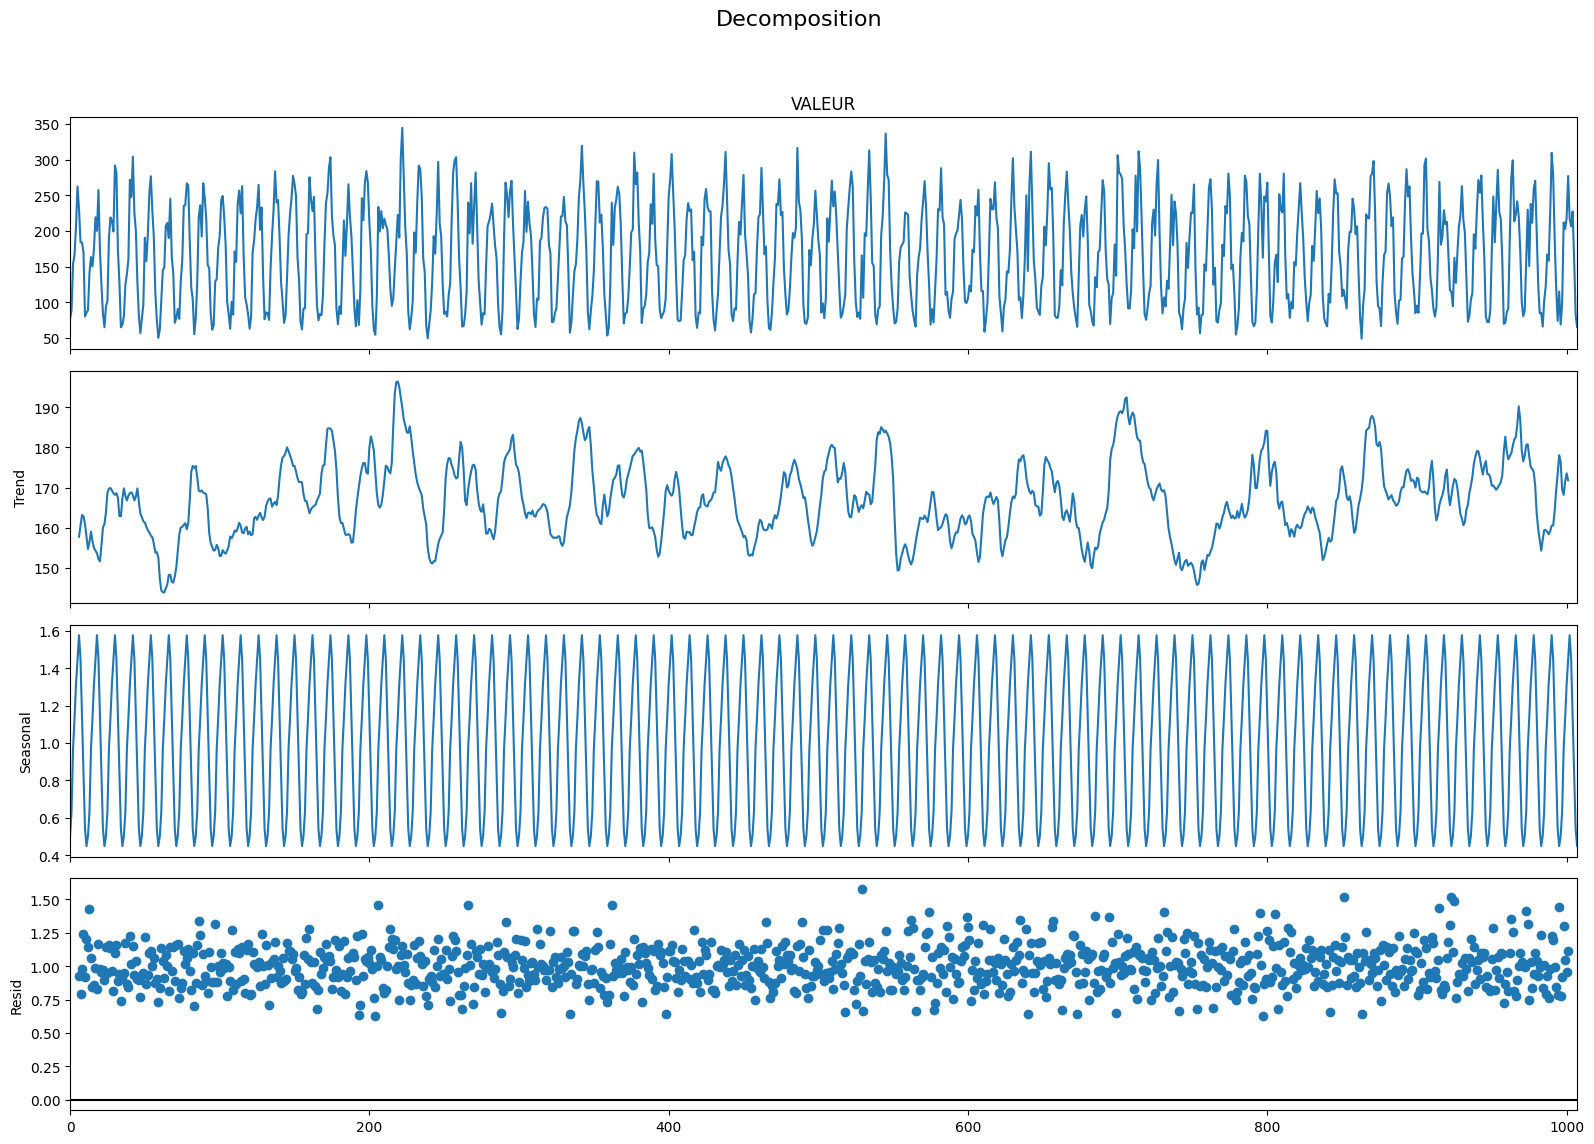

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Appliquer la décomposition saisonnière multiplicative aux données 'VALEUR'
dec_in = seasonal_decompose(mean_monthly_data['VALEUR'], model='multiplicative', period=12)



# Définir la taille de la figure
plt.rcParams.update({'figure.figsize': (16,12)})

# Afficher la décomposition multiplicative
dec_in.plot().suptitle('Decomposition', fontsize=16)

# Ajuster la disposition pour éviter les coupures de titres
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Afficher la figure
plt.show()



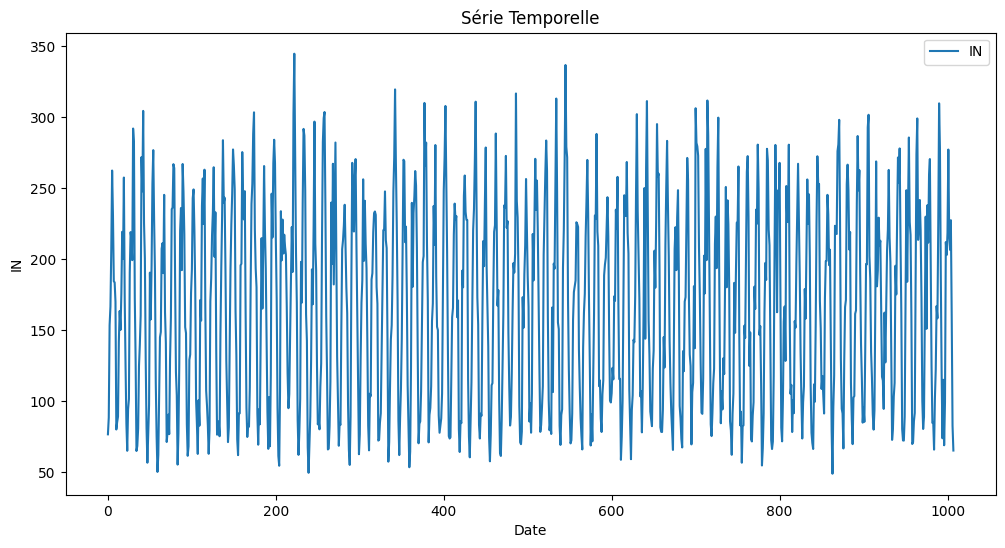

Résultats du test de stationnarité ADF (Augmented Dickey-Fuller):
Statistique de test: -6.8034944633064
Valeur p: 2.2065007072767984e-09
Nombre de lags utilisés: 22
Nombre d'observations utilisées: 985
Valeurs critiques:
	1%: -3.4370062675076807
	5%: -2.8644787205542492
	10%: -2.568334722615888


In [63]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Affichage de la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(mean_monthly_data['VALEUR'], label='IN')
plt.title('Série Temporelle')
plt.xlabel('Date')
plt.ylabel('IN')
plt.legend()
plt.show()

# Effectuer le test de stationnarité ADF sur les données
adf_in_test_result = adfuller(mean_monthly_data['VALEUR'])
print("Résultats du test de stationnarité ADF (Augmented Dickey-Fuller):")
print("Statistique de test:", adf_in_test_result[0])
print("Valeur p:", adf_in_test_result[1])
print("Nombre de lags utilisés:", adf_in_test_result[2])
print("Nombre d'observations utilisées:", adf_in_test_result[3])
print("Valeurs critiques:")
for key, value in adf_in_test_result[4].items():
    print(f"\t{key}: {value}")


Préparation des ensembles d'entraînement et de test avec sélection de la colonne 'VALEUR


In [64]:
# Calcul de la longueur totale des données
data_length = len(mean_monthly_data)

# Définition des proportions pour l'ensemble d'entraînement et l'ensemble de test
train_proportion = 0.98
test_proportion = 1 - train_proportion

# Calcul des tailles des ensembles d'entraînement et de test
train_size = int(data_length * train_proportion)
test_size = data_length - train_size

# Séparation des données en ensembles d'entraînement et de test
train_data = mean_monthly_data.iloc[:train_size]
test_data = mean_monthly_data.iloc[train_size:]

# Sélection de la colonne 'VALEUR' pour l'analyse
X_train = train_data['VALEUR']
X_test = test_data['VALEUR']

# Affichage des tailles des ensembles d'entraînement et de test
train_size, test_size


(987, 21)

RMSE (Root Mean Squared Error) pour le modèle de lissage exponentiel: 27.1000179231038


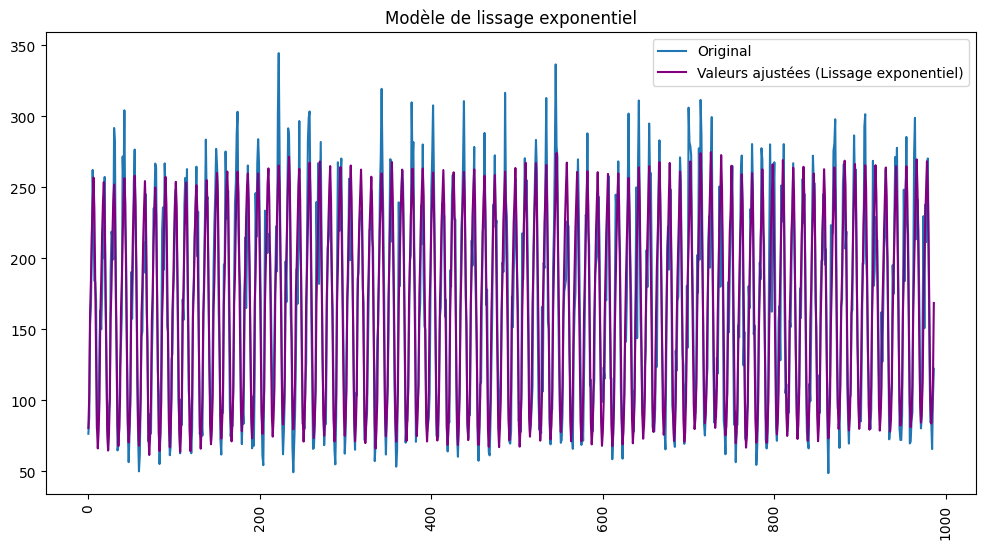

In [65]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Construction du modèle de lissage exponentiel
model_exponential = ExponentialSmoothing(X_train, seasonal='add', seasonal_periods=12)  
# Ajustement du modèle aux données
results_exponential = model_exponential.fit()

# Calcul du RMSE pour évaluer la performance du modèle
rmse_exponential = sqrt(mean_squared_error(X_train, results_exponential.fittedvalues))
print("RMSE (Root Mean Squared Error) pour le modèle de lissage exponentiel:", rmse_exponential)

# Tracé des données originales et des valeurs ajustées par le modèle de lissage exponentiel
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['VALEUR'], label='Original')
plt.plot(train_data.index, results_exponential.fittedvalues, color='purple', label='Valeurs ajustées (Lissage exponentiel)')
plt.xticks(rotation=90)
plt.title('Modèle de lissage exponentiel')
plt.legend()
plt.show()



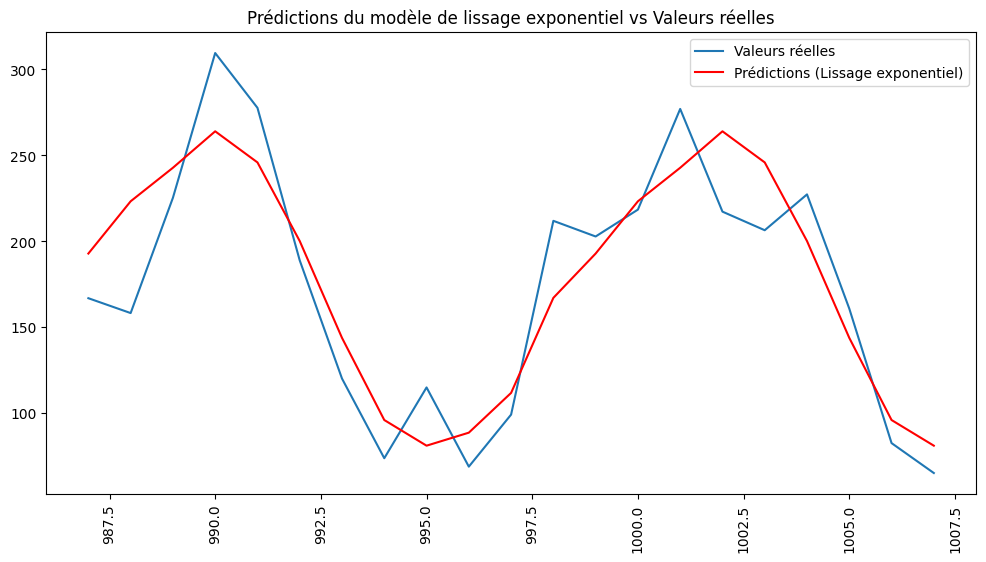

In [66]:
# Prédictions avec le modèle de lissage exponentiel
predictions_exponential = results_exponential.forecast(steps=test_size)

# Préparer la visualisation des prédictions du modèle de lissage exponentiel par rapport aux valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, X_test, label='Valeurs réelles')
plt.plot(test_data.index, predictions_exponential, color='red', label='Prédictions (Lissage exponentiel)')
plt.xticks(rotation=90)
plt.title('Prédictions du modèle de lissage exponentiel vs Valeurs réelles')
plt.legend()
plt.show()


In [67]:
import pickle

In [68]:
with open('model_exponential_IN', 'wb') as f:
    pickle.dump(results_exponential, f)

## Prédiction de la moyenne mensuelle de la température minimale sous abri (en °C et 1/10)

In [69]:
import os
import pandas as pd

# Chemin vers le dossier contenant les fichiers CSV
dossier = './data/SH_RR_metropole/'

# Liste pour stocker les DataFrames chargés à partir des fichiers CSV
dfs = []

# Parcours des fichiers dans le dossier
for fichier in os.listdir(dossier):
    # Vérification si le fichier est un fichier CSV
    if fichier.endswith('.csv'):
        # Construction du chemin complet du fichier
        chemin_fichier = os.path.join(dossier, fichier)
        # Chargement du fichier CSV dans un DataFrame en spécifiant le délimiteur ';' et en sautant les 12 premières lignes
        df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
        # Ajout du DataFrame chargé à la liste
        dfs.append(df)

# Concaténation de tous les DataFrames de la liste en un seul DataFrame
data_TN = pd.concat(dfs, ignore_index=True)

# Sélection des premières 2000 lignes
data_TN = data_TN.head(2000)

# Conversion de la colonne 'YYYYMM' en format de date
data_TN['YYYYMM'] = pd.to_datetime(data_TN['YYYYMM'], format='%Y%m')

# Calcul de la moyenne par mois et création d'un nouveau DataFrame
data_TN_monthly_mean = pd.DataFrame(data_TN.groupby(['YYYYMM']).mean())

# Affichage des premières lignes du DataFrame
data_TN_monthly_mean.head()


,VALEUR,Q_HOM
YYYYMM,,
1951-01-01,195.0,1.0
1951-02-01,160.3,1.0
1951-03-01,258.4,1.0
1951-04-01,141.0,1.0
1951-05-01,175.6,1.0


In [70]:
# Calcul de la moyenne par mois des données météorologiques tunisiennes
tn_mean = data_TN.groupby('YYYYMM').mean()

# Création d'un DataFrame à partir des moyennes mensuelles
tn_mean_df = pd.DataFrame(tn_mean)

# Réinitialisation de l'index
tn_mean_df = tn_mean_df.reset_index()


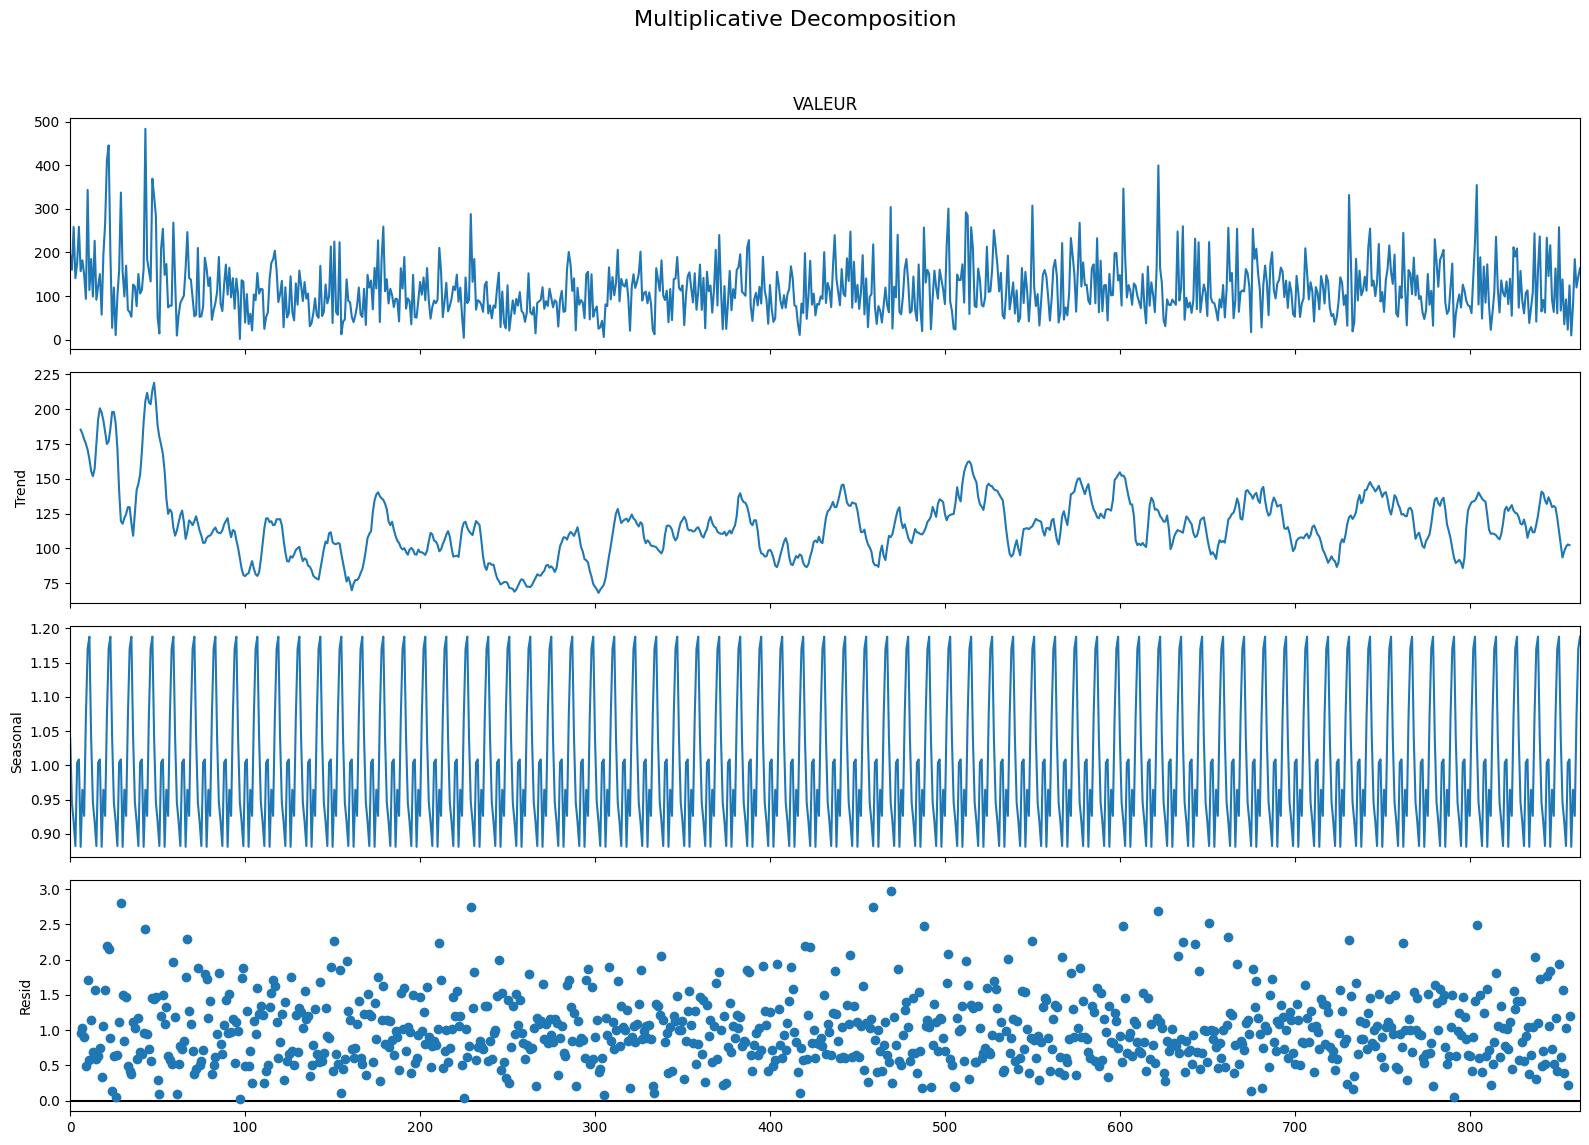

In [71]:
# Utilisation de la méthode seasonal_decompose avec un modèle multiplicatif
multiplicative_decomposition_tn = seasonal_decompose(tn_mean_df['VALEUR'], model='multiplicative', period=12)

# Réglage de la taille de la figure
plt.rcParams.update({'figure.figsize': (16,12)})

# Affichage de la décomposition saisonnière
multiplicative_decomposition_tn.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [72]:
# Calcul de la taille des données
data_length = len(tn_mean_df)
data_length

# Définition des proportions pour l'ensemble d'entraînement et l'ensemble de test
train_proportion = 0.98
test_proportion = 1 - train_proportion

# Calcul de la taille de l'ensemble d'entraînement et de l'ensemble de test
train_size = int(data_length * train_proportion)
test_size = data_length - train_size

# Préparation des séries d'apprentissage et de test
train_df = tn_mean_df.iloc[:train_size]
test_df = tn_mean_df.iloc[train_size:]

# Sélection de la colonne 'VALEUR' pour l'analyse
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

# Affichage des tailles de l'ensemble d'entraînement et de l'ensemble de test
train_size, test_size


(846, 18)

RMSE (Root Mean Squared Error) pour le modèle de lissage exponentiel: 63.58954899707211


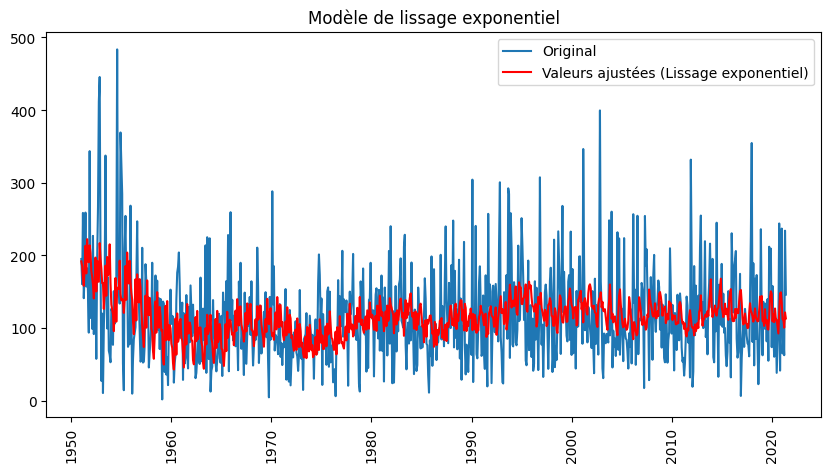

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Construction du modèle de lissage exponentiel
model_exponential = ExponentialSmoothing(X_train, seasonal_periods=12, trend='add', seasonal='add')  
# Ajustement du modèle aux données
results_exponential = model_exponential.fit()

# Calcul du RMSE pour évaluer la performance du modèle
rmse_exponential = sqrt(mean_squared_error(X_train, results_exponential.fittedvalues))
print("RMSE (Root Mean Squared Error) pour le modèle de lissage exponentiel:", rmse_exponential)

# Tracé des données originales et des valeurs ajustées par le modèle de lissage exponentiel
plt.figure(figsize=(10, 5))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_exponential.fittedvalues, color='red', label='Valeurs ajustées (Lissage exponentiel)')
plt.xticks(rotation=90)
plt.title('Modèle de lissage exponentiel')
plt.legend()
plt.show()


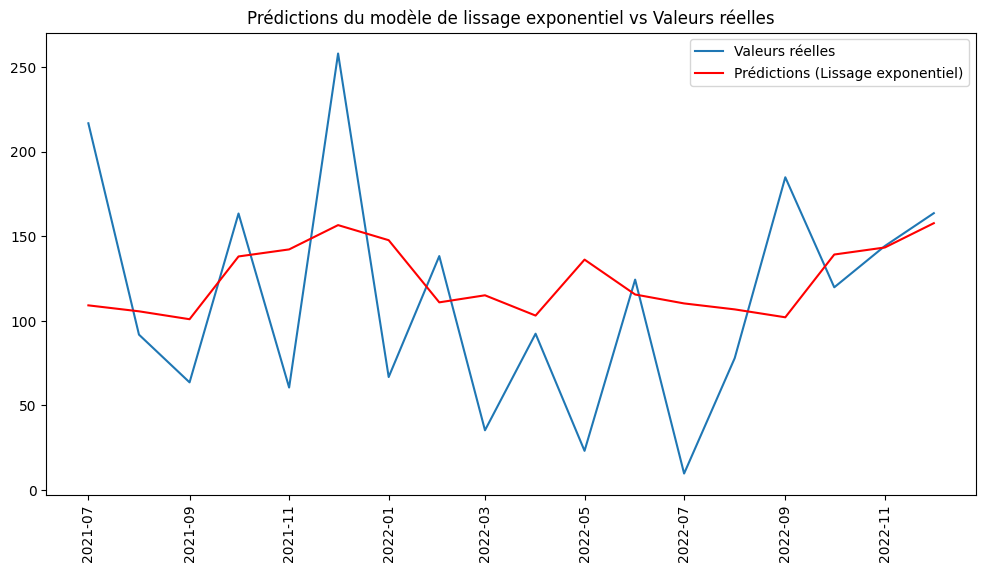

In [74]:
# Prédictions avec le modèle de lissage exponentiel
predictions_exponential = results_exponential.forecast(steps=len(X_test))

# Préparer la visualisation des prédictions du modèle de lissage exponentiel par rapport aux valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Valeurs réelles')
plt.plot(test_df['YYYYMM'], predictions_exponential, color='red', label='Prédictions (Lissage exponentiel)')
plt.xticks(rotation=90)
plt.title('Prédictions du modèle de lissage exponentiel vs Valeurs réelles')
plt.legend()
plt.show()



In [75]:
with open('model_exponential_RR', 'wb') as f:
    pickle.dump(results_exponential, f)

## Prédiction de la moyenne mensuelle de la température maximale sous abri (en °C et 1/10)

In [76]:
import os
import pandas as pd

# Chemin vers le dossier contenant les fichiers CSV
dossier = './data/SH_TN_metropole/'

# Utilisation de la méthode os.listdir() pour obtenir la liste des fichiers dans le dossier
fichiers_csv = [fichier for fichier in os.listdir(dossier) if fichier.endswith('.csv')]

# Création d'une liste pour stocker les DataFrames chargés à partir des fichiers CSV
dfs = []

# Parcours des fichiers dans le dossier
for fichier in fichiers_csv:
    # Construction du chemin complet du fichier
    chemin_fichier = os.path.join(dossier, fichier)
    # Chargement du fichier CSV dans un DataFrame en spécifiant le délimiteur ';' et en sautant les 12 premières lignes
    df = pd.read_csv(chemin_fichier, delimiter=';', skiprows=12)
    # Ajout du DataFrame chargé à la liste
    dfs.append(df)

# Concaténation de tous les DataFrames de la liste en un seul DataFrame
data_TX = pd.concat(dfs, ignore_index=True)

# Sélection des premières 2000 lignes
data_TX = data_TX.head(2000)

# Conversion de la colonne 'YYYYMM' en format de date
data_TX['YYYYMM'] = pd.to_datetime(data_TX['YYYYMM'], format='%Y%m')

# Calcul de la moyenne par mois avec la méthode resample()
data_TX_monthly_mean = data_TX.resample('M', on='YYYYMM').mean()

# Affichage des premières lignes du DataFrame
data_TX_monthly_mean.head()


C:\Users\LTO7\AppData\Local\Temp\ipykernel_24920\1367774892.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_TX_monthly_mean = data_TX.resample('M', on='YYYYMM').mean()


,VALEUR,Q_HOM
YYYYMM,,
1951-01-31,-1.4,1.0
1951-02-28,-1.1,1.0
1951-03-31,0.3,1.0
1951-04-30,4.2,1.0
1951-05-31,7.0,1.0


In [77]:
tx_mean = data_TX.groupby('YYYYMM').mean()
tx_mean_df = pd.DataFrame(tx_mean)
tx_mean_df = tx_mean_df.reset_index()

In [78]:
additive_decomposition_tx = seasonal_decompose(tx_mean_df['VALEUR'], model='additive', period=12)

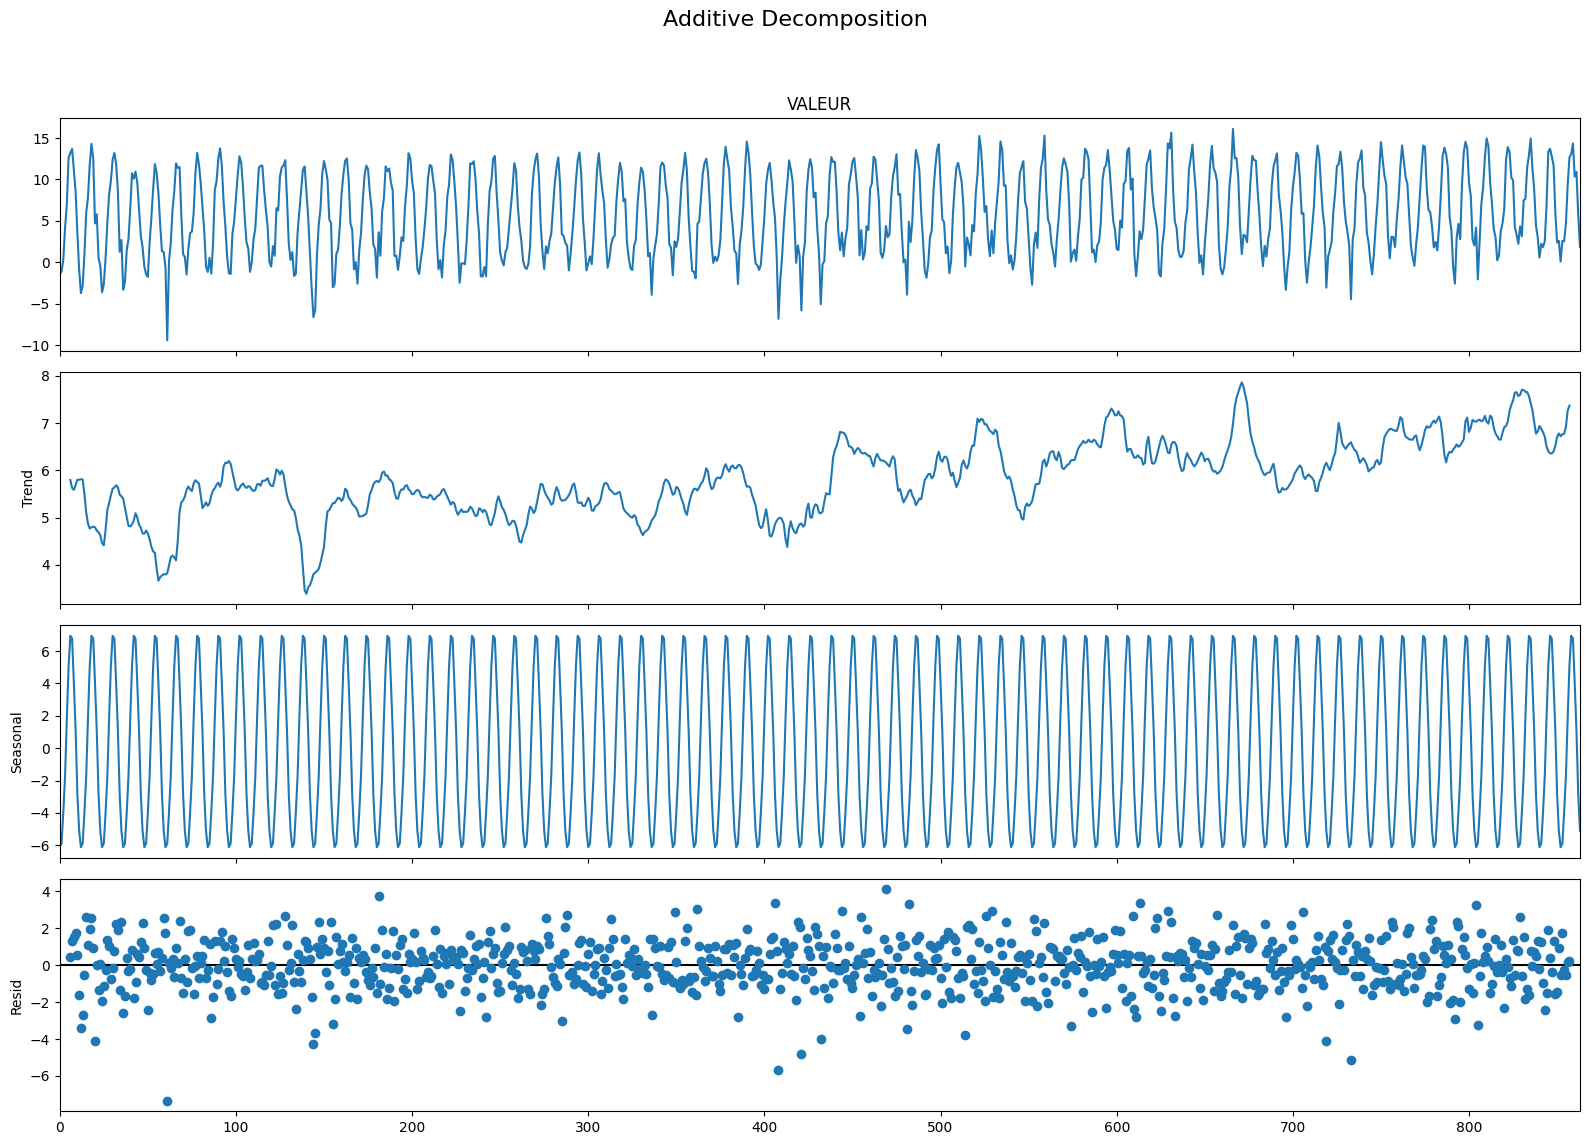

In [79]:
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition_tx.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [80]:
# Calcul de la longueur du DataFrame tx_mean_df
data_length = len(tx_mean_df)

# Affichage de la longueur des données
print("Longueur des données:", data_length)

# Définition de la taille de l'ensemble d'entraînement (80%) et de l'ensemble de test (20%)
train_size = int(data_length * 0.8)
test_size = data_length - train_size

# Affichage des tailles de l'ensemble d'entraînement et de l'ensemble de test
print("Taille de l'ensemble d'entraînement:", train_size)
print("Taille de l'ensemble de test:", test_size)

# Séparation des données en ensembles d'entraînement et de test
train_df = tx_mean_df.iloc[:train_size]
test_df = tx_mean_df.iloc[train_size:]

# Sélection de la colonne 'VALEUR' pour l'ensemble d'entraînement et de test
X_train = train_df['VALEUR']
X_test = test_df['VALEUR']

# Affichage des tailles de l'ensemble d'entraînement et de l'ensemble de test après la division
print("Taille de l'ensemble d'entraînement après la division:", len(train_df))
print("Taille de l'ensemble de test après la division:", len(test_df))


Longueur des données: 864
Taille de l'ensemble d'entraînement: 691
Taille de l'ensemble de test: 173
Taille de l'ensemble d'entraînement après la division: 691
Taille de l'ensemble de test après la division: 173


RMSE (Root Mean Squared Error) pour le modèle de lissage exponentiel: 1.475682327200085


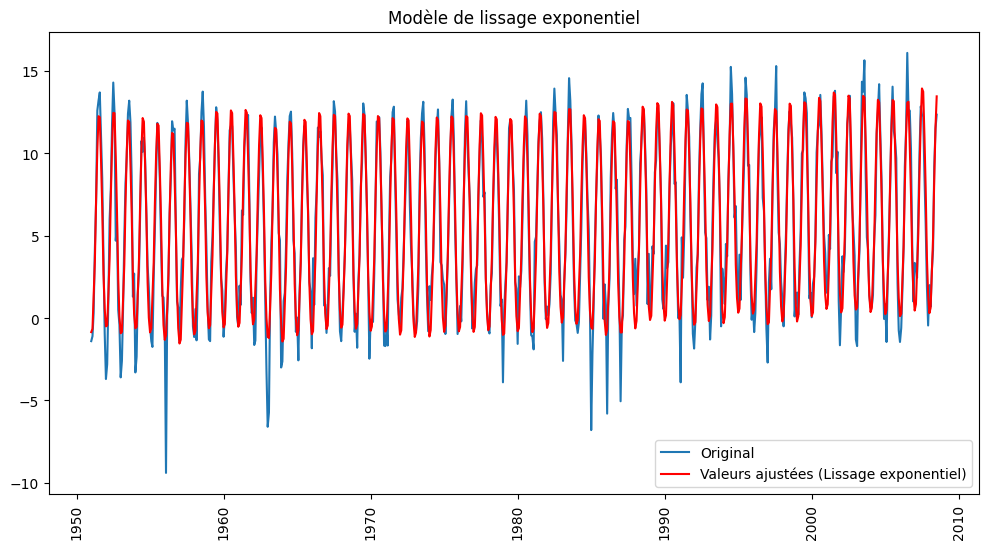

In [81]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Construction du modèle de lissage exponentiel Holt-Winters
model_exponential = ExponentialSmoothing(X_train, seasonal_periods=12, trend='add', seasonal='add')  
# Ajustement du modèle aux données
results_exponential = model_exponential.fit()

# Calcul du RMSE pour évaluer la performance du modèle
rmse_exponential = sqrt(mean_squared_error(X_train, results_exponential.fittedvalues))
print("RMSE (Root Mean Squared Error) pour le modèle de lissage exponentiel:", rmse_exponential)

# Tracé des données originales et des valeurs ajustées par le modèle de lissage exponentiel
plt.figure(figsize=(12, 6))
plt.plot(train_df['YYYYMM'], train_df['VALEUR'], label='Original')
plt.plot(train_df['YYYYMM'], results_exponential.fittedvalues, color='red', label='Valeurs ajustées (Lissage exponentiel)')
plt.xticks(rotation=90)
plt.title('Modèle de lissage exponentiel')
plt.legend()
plt.show()


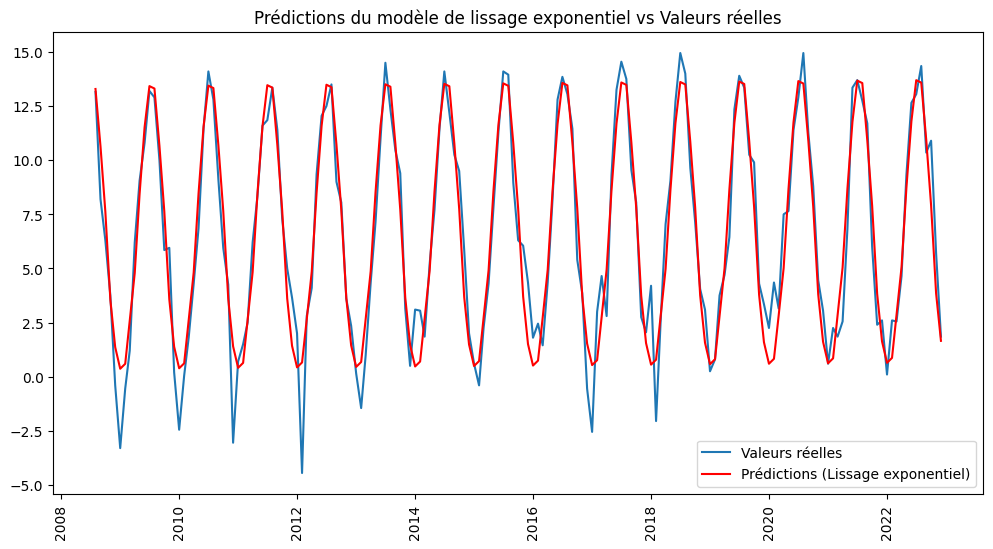

In [82]:
# Prédictions avec le modèle de lissage exponentiel Holt-Winters
predictions_exponential = results_exponential.forecast(steps=len(X_test))

# Préparer la visualisation des prédictions du modèle de lissage exponentiel par rapport aux valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['YYYYMM'], X_test, label='Valeurs réelles')
plt.plot(test_df['YYYYMM'], predictions_exponential, color='red', label='Prédictions (Lissage exponentiel)')
plt.xticks(rotation=90)
plt.title('Prédictions du modèle de lissage exponentiel vs Valeurs réelles')
plt.legend()
plt.show()


In [83]:
with open('model_exponential_TN', 'wb') as f:
    pickle.dump(results_exponential, f)